In [4]:
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from numpy import loadtxt
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
image_size = 224
batch_size = 32

In [6]:
    

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.4,
        
        validation_split = 0.4,
        horizontal_flip=True,
        samplewise_center=True, 
        samplewise_std_normalization=True, 
        vertical_flip = True, 
        height_shift_range= 0.05, 
        width_shift_range=0.2, 
        rotation_range=5, 
        fill_mode = 'reflect',
        zoom_range=0.2)

    train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/AI - DEEP LEARNING ASSIGNMENTS/pgs/data',
         target_size=(image_size, image_size),
         batch_size=batch_size,
        class_mode='categorical',
        subset = 'training',
        shuffle = True
         )
    validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/AI - DEEP LEARNING ASSIGNMENTS/pgs/data',
     
         target_size=(image_size, image_size),
         batch_size=batch_size,
        class_mode='categorical',
        subset = 'validation',
        shuffle = True
         )



Found 2597 images belonging to 5 classes.
Found 1726 images belonging to 5 classes.


In [7]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

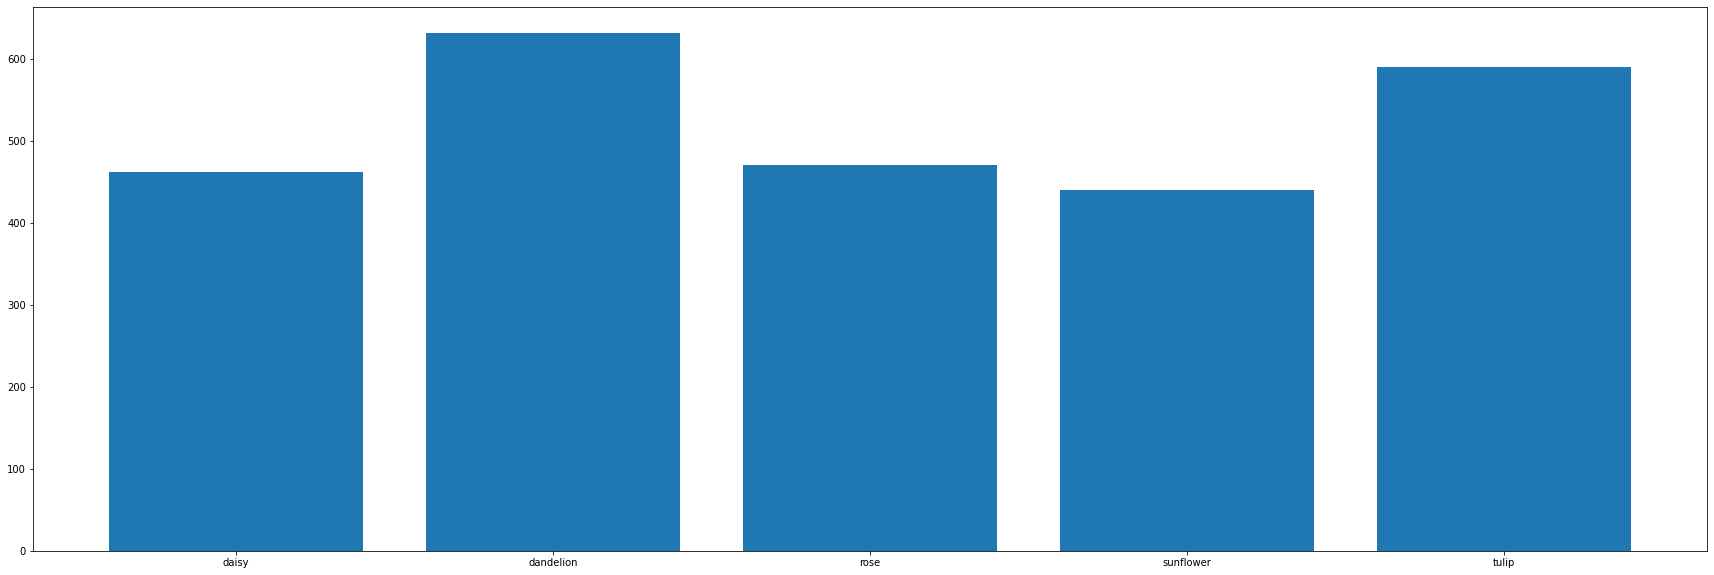

In [8]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

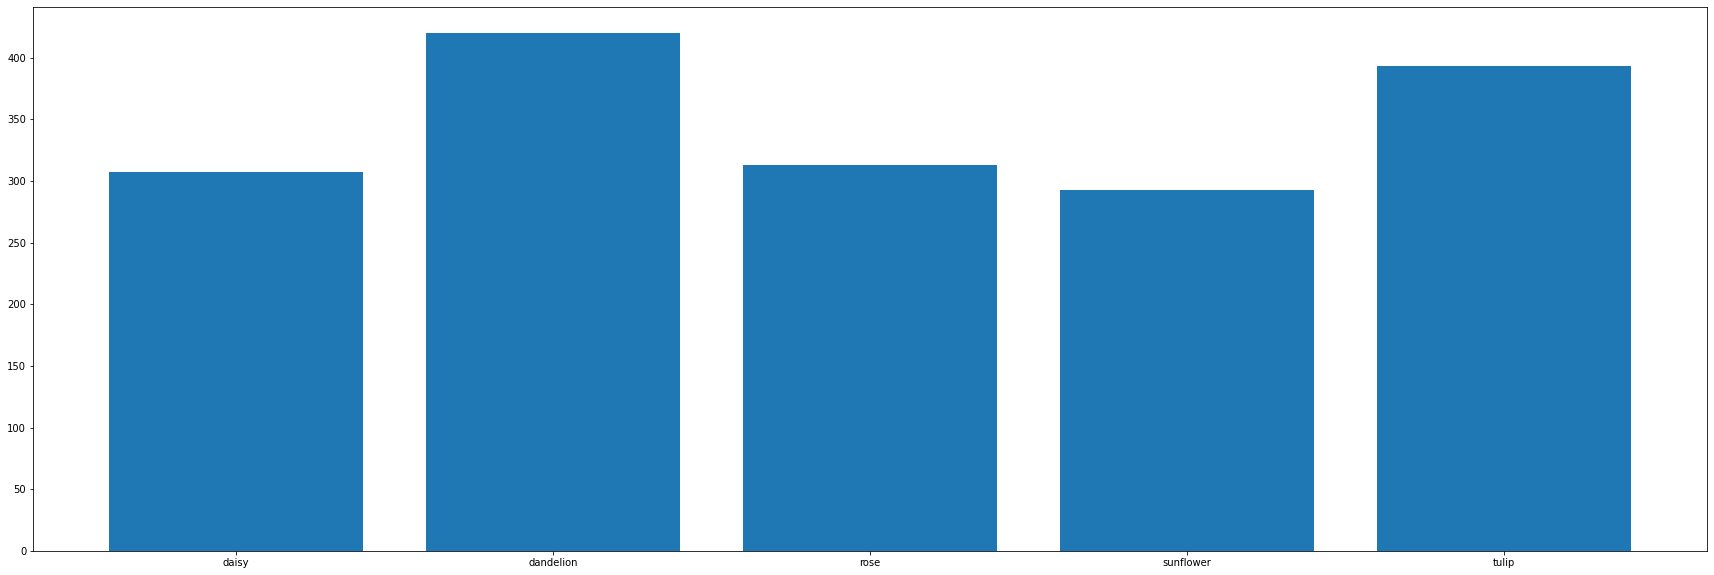

In [9]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = validation_generator.classes
from collections import OrderedDict


classes = list(validation_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

In [10]:

pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

In [11]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [13]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 26
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=26,
    verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/26
26/26 - 598s - loss: 1.2131 - accuracy: 0.5689 - val_loss: 1.3572 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 1.35722, saving model to inceptionv3_best.h5
Epoch 2/26
26/26 - 443s - loss: 0.8810 - accuracy: 0.7163 - val_loss: 0.9233 - val_accuracy: 0.6938

Epoch 00002: val_loss improved from 1.35722 to 0.92326, saving model to inceptionv3_best.h5
Epoch 3/26
26/26 - 328s - loss: 0.8211 - accuracy: 0.7296 - val_loss: 0.8715 - val_accuracy: 0.6812

Epoch 00003: val_loss improved from 0.92326 to 0.87153, saving model to inceptionv3_best.h5
Epoch 4/26
26/26 - 233s - loss: 0.8168 - accuracy: 0.7130 - val_loss: 1.2448 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.87153
Epoch 5/26
26/26 - 194s - loss: 0.7638 - accuracy: 0.7127 - val_loss: 0.7560 - val_accuracy: 0.7312

Epoch 00005: val_loss improved from 0.87153 to 0.75595, saving model to inceptionv3_best.h5
Epoch 6/26
26/26 - 169s - loss: 0.6076 - accuracy: 0.7800 - val_loss: 0.8891 - v

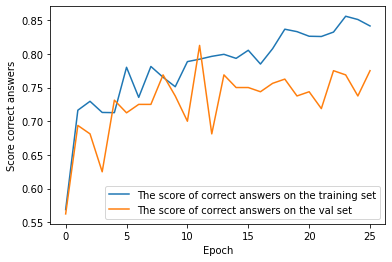

In [15]:
plt.plot(history.history['accuracy'], label='The score of correct answers on the training set')
plt.plot(history.history['val_accuracy'], label='The score of correct answers on the val set')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

In [18]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG/2880px-Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG

--2021-05-29 21:02:33--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG/2880px-Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1631195 (1.6M) [image/jpeg]
Saving to: ‘2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG’

2880px-Iglesia_de_N 100%[===================>]   1.55M  1.46MB/s    in 1.1s    

2021-05-29 21:02:35 (1.46 MB/s) - ‘2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG’ saved [1631195/1631195]



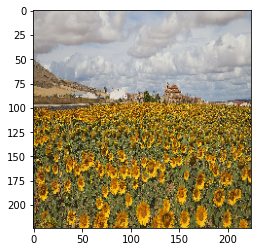

In [19]:
img_path = '/content/2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG'

img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [20]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)

prediction

array([[2.8125590e-04, 1.4398804e-02, 4.6867106e-04, 9.8055631e-01,
        4.2949333e-03]], dtype=float32)

In [21]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[3]
